# 序列模型

## 自回归
预测一个数据时，不是用的其他数据，而是用的这个数据前面的数据

## 方案A--马尔可夫假设
假设当前数据只跟前 m 个过去数据点相关

## 方案B--潜变量模型
引入潜变量ht来表示过去的信息 

## 总结
1. 时序模型中，当前的数据跟之前观察到的数据相关
2. 自回归模型使用自身过去数据来预测未来
3. 马尔可夫模型假设当前只跟少数数据相关，从而简化模型
4. 潜变量模型使用潜变量来概括历史信息

# 用马尔可夫假设训练一个MLP来预测模型
使用正弦函数和一些可加性噪音来生成序列数据，时间步长为1， 2， ... , 1000

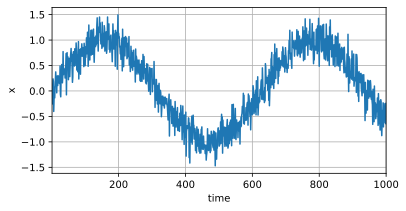

In [3]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6,3))

接下来，我们将这个序列转换为模型的*特征－标签*（feature-label）对。
基于嵌入维度$\tau$，我们[**将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]
这比我们提供的数据样本少了$\tau$个，
因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；
另一个方法是用零填充序列。
在这里，我们仅使用前600个“特征－标签”对进行训练。


In [4]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练。 将数组变成可以迭代的iter
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [5]:
# 使用一个相当简单的结构：一个拥有两个全连接层的多层感知机
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [9]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.061964
epoch 2, loss: 0.054798
epoch 3, loss: 0.049838
epoch 4, loss: 0.048715
epoch 5, loss: 0.047826


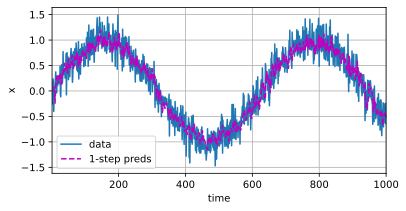

In [10]:
# 模型预测下一个时间步
onestep_preds = net(features)
d2l.plot([time, time[tau: ]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6,3))

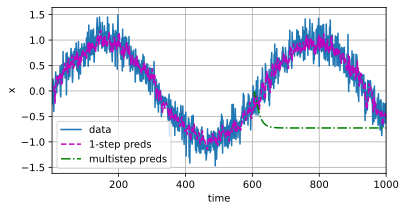

In [11]:
# 多步预测，错的很离谱
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))